# Imports

In [246]:
import pyarrow as pa
import pyarrow.parquet as pq

import pandas as pd

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import numpy as np

from scipy.stats import pearsonr, spearmanr

import geopandas as gpd #heatmap
import plotly.graph_objects as go

import json

In [247]:
MRD = 10**9

# Data loading

### BTC data

In [248]:
btc_price_data = pd.read_csv("data/BTC_ALL_graph_coinmarketcap.csv",sep=";")

#split off time of day
btc_price_data["timestamp"] = btc_price_data["timestamp"].apply(lambda x: str(x).split("T")[0]) 
btc_price_data = btc_price_data[["high", "timestamp"]]
btc_price_data.rename(columns={"timestamp": "date"}, inplace=True)


btc_price_data["year"] = btc_price_data["date"].apply(lambda x: int(str(x).split("-")[0]))

btc_price_data = btc_price_data[btc_price_data['year'] >= 2011]

display(btc_price_data.tail())

,high,date,year
726,26550.072937,2023-05-04,2023
727,25148.010374,2023-05-11,2023
728,25338.472061,2023-05-17,2023
729,25279.405768,2023-05-24,2023
730,26131.181703,2023-05-30,2023


### Actors data

In [249]:
actors = pq.read_table("data/actors.parquet")
actors_df = actors.to_pandas()

actors_df

,id,uri,label,jurisdictions,categories
0,bilaxy,bilaxy.com,Bilaxy,HK,exchange
1,banxa,banxa.com,Banxa,"AU, NL, US",exchange
2,aax,www.aax.com,Aax,SC,exchange
3,altcointrader,www.altcointrader.co.za,AltcoinTrader,ZA,exchange
4,azbit,azbit.com,Azbit,MH,exchange
...,...,...,...,...,...
309,stocksexchange,stex.com,Stex,EE,exchange
310,smenarnabitcoin,smenarnabitcoin.cz,Smenarnabitcoin,CZ,exchange
311,xapo,xapo.com,Xapo,US,"exchange, service"
312,yobit,yobit.net,YoBit,RU,exchange


### Flow data

In [250]:
flows = pq.read_table("data/flows.parquet")
flows_df = flows.to_pandas()

flows_df

,src_id,dst_id,value_asset,value_USD,date
0,1coin,1coin,36870000,243.755870,2014-03-03
1,1coin,1coin,380120000,2378.899210,2014-03-10
2,1coin,1coin,429150403,2738.687542,2014-03-13
3,1coin,1coin,333900098,2092.574397,2014-03-14
4,1coin,1coin,779334803,4938.373652,2014-03-15
...,...,...,...,...,...
1939582,zyado,zyado,1019592,11.368847,2017-03-21
1939583,zyado,zyado,1004152,13.325487,2017-04-29
1939584,zyado,zyado,39850720,5966.967603,2018-01-10
1939585,zyado,zyado,19251202,1730.115174,2018-04-27


### Country Codes

In [251]:
# Load country codes (source: https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes)
country_codes = pd.read_csv('data/country_codes.csv')

display(country_codes.head())

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


### GDP (PPP) Data

In [252]:
# Load GDP data (PPP) (Source: https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD)
gdp = pd.read_csv('data/gdp.csv', skiprows=3)
gdp_meta = pd.read_csv('data/gdp_meta.csv')

display(gdp.head())
display(gdp_meta.head())

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,36846.848285,37343.912963,37583.840323,38865.188195,41679.238190,42501.641554,34971.009913,42698.359872,NaN,NaN
1,Africa Eastern and Southern,AFE,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3470.550675,3498.125396,3591.099809,3635.564622,3724.868177,3777.972368,3621.058106,3839.470058,NaN,NaN
2,Afghanistan,AFG,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2110.829568,2128.125938,2023.834656,2096.093111,2109.929296,2167.704111,2076.138380,1665.805842,NaN,NaN
3,Africa Western and Central,AFW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4143.177054,4075.994459,3998.951876,4045.303263,4160.540965,4264.731035,4174.504565,4409.450961,NaN,NaN
4,Angola,AGO,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,8123.048065,7274.090475,7027.146634,7216.061373,7042.923829,6881.076241,6362.636076,6491.125578,NaN,NaN


,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,NaN,Aruba,NaN
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern,NaN
2,AFG,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,NaN
3,AFW,NaN,NaN,"22 countries, stretching from the westernmost ...",Africa Western and Central,NaN
4,AGO,Sub-Saharan Africa,Lower middle income,The World Bank systematically assesses the app...,Angola,NaN


### Overall BTC Trading Volume

In [253]:
trading_volume = pd.read_csv('data/bitcoin_trading_volume.csv')
trading_volume.Time = pd.to_datetime(trading_volume.Time)
trading_volume['year'] = trading_volume.Time.dt.year

display(trading_volume)

,Time,price,volume,year
0,2010-07-01 00:00:00+00:00,0.064460,1.966753e+03,2010
1,2010-08-01 00:00:00+00:00,0.064572,1.428969e+04,2010
2,2010-09-01 00:00:00+00:00,0.061903,1.344608e+04,2010
3,2010-10-01 00:00:00+00:00,0.108899,1.173847e+05,2010
4,2010-11-01 00:00:00+00:00,0.258841,2.237274e+05,2010
...,...,...,...,...
150,2023-01-01 00:00:00+00:00,20415.513027,2.299786e+10,2023
151,2023-02-01 00:00:00+00:00,23743.338494,1.333384e+10,2023
152,2023-03-01 00:00:00+00:00,25618.094071,2.468627e+10,2023
153,2023-04-01 00:00:00+00:00,29181.453834,1.686690e+10,2023


## Juri names Long


In [254]:
with open('data/country_names_long.json', 'r') as file:
    juri_names_long = json.load(file)



for name in juri_names_long:
    if len(name) > 15:
        name = name[:15]+"."

### Population data

In [255]:
# Load Population data (Source: https://data.worldbank.org/indicator/SP.POP.TOTL)
population = pd.read_csv('data/population.csv', skiprows=3)

display(population.head())

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,...,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,NaN,NaN
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,...,583650827.0,600008150.0,616377331.0,632746296.0,649756874.0,667242712.0,685112705.0,702976832.0,NaN,NaN
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,...,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,NaN,NaN
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,97256290.0,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,...,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0,478185907.0,NaN,NaN
4,Angola,AGO,"Population, total",SP.POP.TOTL,5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,...,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0,34503774.0,NaN,NaN


### Tax Haven data

In [256]:
# Load tax haven data (Source: https://www.taxjustice.net)
cthi_2021 = pd.read_csv('data/cthi_2021.csv', sep=';')[['Country', 'Haven Score']]
cthi_2019 = pd.read_csv('data/cthi_2019.csv', sep=';')[['Country', 'Haven Score']]
cthi_2019['Haven Score'] = cthi_2019['Haven Score'].str.replace(',', '.').astype('float')
cthi_2021['Haven Score'] = cthi_2021['Haven Score'].str.replace(',', '.').astype('float')

# If both datapoints are available for a country we average over the 2021 and 2019 score

cthi = pd.merge(cthi_2019, cthi_2021, on='Country', how='outer')
print(f'Shape {cthi.shape[0]}')
cthi['Haven Score'] = cthi[['Haven Score_x', 'Haven Score_y']].mean(axis=1, skipna=True).fillna(0)
cthi.drop(columns=['Haven Score_x', 'Haven Score_y'], inplace=True)

display(cthi.head())

Shape 77


,Country,Haven Score
0,Andorra,65.175
1,Anguilla,100.000
2,Aruba,67.245
3,Austria,53.645
4,Bahamas,100.000


### Corruption data

In [257]:
# Load Corruption Perception data (Source: https://www.transparency.org via https://www.kaggle.com/datasets/jeegarmaru/corruption-perceptions-index-for-10-years?select=merged_cpi_data.csv)
cpi = pd.read_csv('data/cpi_data.csv')

display(cpi.head())

,Year,Country,CPI Score,Rank,Number of Sources,Minimum score,Maximum score,Standard Error,90% Confidence Interval (Higher bound),90% Confidence Interval (Lower bound),...,WJP,ISO3,Region,WB Code,OECD,G20,BRICS,EU,Arab states,IFS Code
0,2010,Denmark,93.0,1,6,89.0,95.0,2.0,94.0,91.0,...,NaN,DNK,WE/EU,DNK,y,NaN,NaN,y,NaN,128.0
1,2010,New Zealand,93.0,1,6,89.0,95.0,2.0,95.0,92.0,...,NaN,NZL,AP,NZL,y,NaN,NaN,NaN,NaN,196.0
2,2010,Singapore,93.0,1,9,89.0,95.0,2.0,94.0,92.0,...,NaN,SGP,AP,SGP,NaN,NaN,NaN,NaN,NaN,576.0
3,2010,Finland,92.0,4,6,89.0,95.0,2.0,93.0,91.0,...,NaN,FIN,WE/EU,FIN,y,NaN,NaN,y,NaN,172.0
4,2010,Sweden,92.0,4,6,89.0,95.0,2.0,94.0,91.0,...,NaN,SWE,WE/EU,SWE,y,NaN,NaN,y,NaN,144.0


# Data exploration

Inspect general information about the flow dataset

In [258]:
print(f'Number of rows in the flow dataset {flows_df.shape[0]}')
print(f'First flow: {flows_df.date.min()}, last flow: {flows_df.date.max()}')

common_values = flows_df.src_id.value_counts().index.union(flows_df.dst_id.value_counts().index)
print(f"Entity Count: {len(common_values)}")



# TODO RETHINK THIS
'''
filtered_flows_df = flows_df.loc[flows_df.src_id != flows_df.dst_id]

print(f'Number of rows with different src/dst  the flow dataset {filtered_flows_df.shape[0]}')

sum_before = int(flows_df["value_USD"].sum() / MRD)
sum_after = int(filtered_flows_df["value_USD"].sum() / MRD)

count_before = flows_df["value_USD"].count()
count_after = filtered_flows_df["value_USD"].count()

print(f'Filtering trimmed the dataset from {sum_before} MRD USD to {sum_after} MRD USD ({100*(sum_after/sum_before)}% left)')
print(f'Filtering trimmed the dataset from {count_before} TX  to {count_after} TX  ({100*(count_after/count_before)}% left)')
'''


filtered_flows_df = flows_df

Number of rows in the flow dataset 1939587
First flow: 2011-05-13, last flow: 2023-04-12
Entity Count: 290


Category distribution


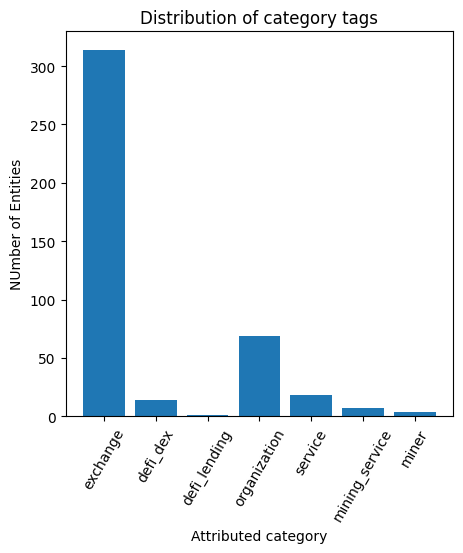

In [259]:
print('Category distribution')
counts = actors_df.categories.value_counts()
#print(counts)

values = actors_df.categories.unique()
actual_values = {}
for value in values:
    for v in value.split(", "):
        if not v in actual_values:
            actual_values[v] =0
        actual_values[v] = actual_values[v]+counts[value]

#print(actual_values)

plt.figure(figsize=(5, 5)) 
plt.bar(actual_values.keys(), actual_values.values())
plt.xlabel('Attributed category')
plt.ylabel('NUmber of Entities')
plt.title('Distribution of category tags')
plt.tick_params(axis='x', rotation=60)
plt.savefig('figs/category_tags.png')
plt.show()

Lets see how the jurisdictions are "distributed"

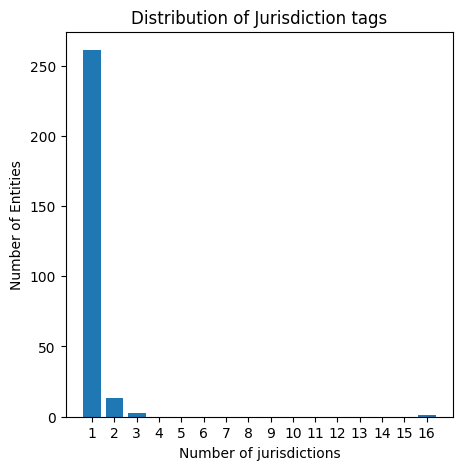

jurisdictions
1     261
2      13
3       3
16      1
Name: count, dtype: int64

In [260]:
# Compute the comma count for each value in the "jurisdictions" column
all_actors_in_flow_data = flows_df.src_id.value_counts().index.union(flows_df.dst_id.value_counts().index)
filtered_actors = actors_df[actors_df.id.str.lower().isin(all_actors_in_flow_data)]
comma_count_stats = filtered_actors['jurisdictions'].apply(lambda x: str(x).count(',')+1).value_counts().sort_index()

plt.figure(figsize=(5, 5)) 
plt.bar(comma_count_stats.index, comma_count_stats.values)
plt.xlabel('Number of jurisdictions')
plt.ylabel('Number of Entities')
plt.xticks(range(1, max(comma_count_stats.index) + 1), range(1, max(comma_count_stats.index) + 1))
plt.title('Distribution of Jurisdiction tags')
plt.savefig('figs/juri_tags.png')
plt.show()

comma_count_stats

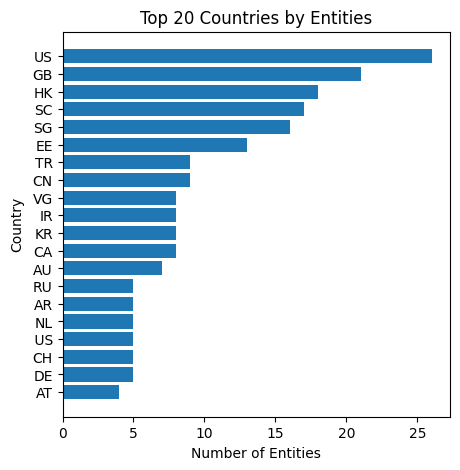

In [261]:
# Check distribution of jurisdictions
actors_jurisdictions = filtered_actors.assign(jurisdictions=filtered_actors.jurisdictions.str.split(','))
actors_jurisdictions = actors_jurisdictions.explode('jurisdictions')
jurisdiction_distribution = actors_jurisdictions.jurisdictions.value_counts().head(20)

plt.figure(figsize=(5, 5)) 
plt.barh(jurisdiction_distribution.index[::-1], jurisdiction_distribution.values[::-1])
plt.xlabel('Number of Entities')
plt.ylabel('Country')
#plt.xticks(range(1, 25), range(1, 25))
plt.title('Top 20 Countries by Entities')
plt.savefig('figs/juri_entities.png')
plt.show()

In which timeframe was the flow data collected?

In [262]:
# Flow data from - to
print(f'Flow data recorded from {flows_df.date.min()} to {flows_df.date.max()}')

Flow data recorded from 2011-05-13 to 2023-04-12


In [263]:
print(f'Flows before merging actor data {flows_df.shape[0]}')
merged_df = pd.merge(filtered_flows_df, actors_df.add_prefix('src_'), on='src_id', how='inner')
merged_df = pd.merge(merged_df, actors_df.add_prefix('dst_'), on='dst_id', how='inner')
print(f'Flows after merging actor data {merged_df.shape[0]}')
display(merged_df.head())

Flows before merging actor data 1939587


Flows after merging actor data 1904481


,src_id,dst_id,value_asset,value_USD,date,src_uri,src_label,src_jurisdictions,src_categories,dst_uri,dst_label,dst_jurisdictions,dst_categories
0,1coin,1coin,36870000,243.755870,2014-03-03,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
1,1coin,1coin,380120000,2378.899210,2014-03-10,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
2,1coin,1coin,429150403,2738.687542,2014-03-13,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
3,1coin,1coin,333900098,2092.574397,2014-03-14,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
4,1coin,1coin,779334803,4938.373652,2014-03-15,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange


In [264]:
# merge in btc course data
merged_df = pd.merge(merged_df,btc_price_data,on="date",how='inner')

In [265]:
# Types
merged_df['date'] = pd.to_datetime(merged_df['date'])

lets see how much of the traffic is from or to binance

,value_usd_with,value_usd_without,binance portion
year,,,
2011,1.345420e+04,1.345420e+04,0.000000
2012,3.172178e+05,3.172178e+05,0.000000
2013,4.137246e+07,4.137246e+07,0.000000
2014,3.008547e+08,3.008547e+08,0.000000
2015,8.015531e+08,8.015531e+08,0.000000
2016,1.853461e+09,1.853461e+09,0.000000
2017,1.606032e+10,1.447801e+10,9.852298
2018,2.139878e+10,1.502060e+10,29.806291
2019,2.866707e+10,2.417080e+10,15.684417


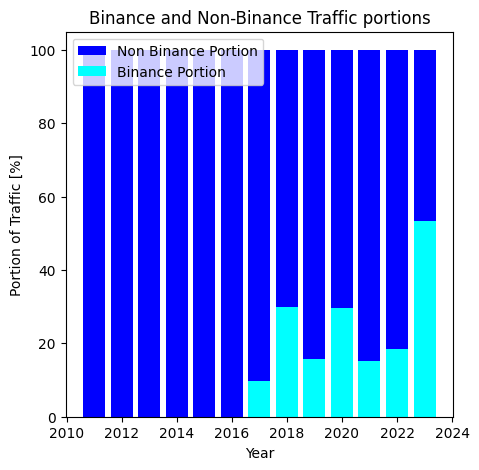

In [362]:
# calc overall traffic per year
yearly = merged_df.groupby(["year"])["value_USD"].sum().reset_index()
yearly.rename(columns={"value_USD":"value_usd_with"},inplace=True)

yearly_without_binance = merged_df[merged_df["src_label"].str.contains("inance") == False]
yearly_without_binance = yearly_without_binance[yearly_without_binance["dst_label"].str.contains("inance") == False]

yearly["value_usd_without"] = yearly_without_binance.groupby(["year"])["value_USD"].sum().reset_index()["value_USD"]
yearly["binance portion"] = (1-(yearly["value_usd_without"]/yearly["value_usd_with"]))*100

yearly.set_index('year',inplace=True)
display(yearly)



# Create a figure and axes
plt.figure(figsize=(5,5))

# Plot the data
plt.bar(yearly.index,100,color='blue',label="Non Binance Portion")
plt.bar(yearly.index, yearly['binance portion'], color='cyan',label="Binance Portion")

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Portion of Traffic [%]')
plt.title('Binance and Non-Binance Traffic portions')


plt.legend(loc='upper left',ncol=1)

# Display the plot
plt.show()


In [267]:
# Compare value per year with overall BTC trading volume
# TODO FIX THIS
# NameError: name 'volume' is not defined
'''
yearly_flow = yearly.copy()
volume_year = trading_volume.groupby(["year"])['volume'].sum().reset_index()
merged_volume = pd.merge(yearly_flow, volume_year, on='year', how='inner').reset_index()

display(merged_volume)

fig, ax = plt.subplots()
bottom = np.zeros(3)
width=0.8

for yearly_volume in merged_volume.iterrows():
    year = yearly_volume[1].year
    value_flow = yearly_volume[1].value_usd_with
    relative_value_flow = value_flow / volume
    volume = yearly_volume[1].volume
    ax.bar(year, relative_value_flow, width, label=year, bottom=0, color='blue')
    ax.bar(year, 1 - relative_value_flow, width, label=year, bottom=relative_value_flow, color='gray')

ax.set_title("Share of overall trading volume captured")

plt.show()
'''

'\nyearly_flow = yearly.copy()\nvolume_year = trading_volume.groupby(["year"])[\'volume\'].sum().reset_index()\nmerged_volume = pd.merge(yearly_flow, volume_year, on=\'year\', how=\'inner\').reset_index()\n\ndisplay(merged_volume)\n\nfig, ax = plt.subplots()\nbottom = np.zeros(3)\nwidth=0.8\n\nfor yearly_volume in merged_volume.iterrows():\n    year = yearly_volume[1].year\n    value_flow = yearly_volume[1].value_usd_with\n    relative_value_flow = value_flow / volume\n    volume = yearly_volume[1].volume\n    ax.bar(year, relative_value_flow, width, label=year, bottom=0, color=\'blue\')\n    ax.bar(year, 1 - relative_value_flow, width, label=year, bottom=relative_value_flow, color=\'gray\')\n\nax.set_title("Share of overall trading volume captured")\n\nplt.show()\n'

### Split by juritags

In [268]:
# Transform jurisdiction string into list element
expanded_df = merged_df.copy()
expanded_df.src_jurisdictions = expanded_df.src_jurisdictions.fillna("")
expanded_df.dst_jurisdictions = expanded_df.dst_jurisdictions.fillna("")
expanded_df = expanded_df.assign(src_jurisdictions=expanded_df.src_jurisdictions.str.split(','))
expanded_df = expanded_df.assign(dst_jurisdictions=expanded_df.dst_jurisdictions.str.split(','))

# Split up amounts by number of src and dst countries
expanded_df['value_asset'] = expanded_df.apply(lambda row: row['value_asset'] / max(len(row.src_jurisdictions) * len(row.dst_jurisdictions), 1) , axis=1)
expanded_df['value_USD'] = expanded_df.apply(lambda row: row['value_USD'] / max(len(row.src_jurisdictions) * len(row.dst_jurisdictions), 1), axis=1)

# Create separate columns for each jurisdiction (if we want to split the amounts we have to split amount before)
expanded_df = expanded_df.explode('dst_jurisdictions')
expanded_df = expanded_df.explode('src_jurisdictions')


# Strip whitespace
expanded_df.dst_jurisdictions = expanded_df.dst_jurisdictions.str.strip()
expanded_df.src_jurisdictions = expanded_df.src_jurisdictions.str.strip()

expanded_df_with_inland = expanded_df.copy()
# Remove flows which aren't x-border
expanded_df_without_inland = expanded_df[expanded_df['dst_jurisdictions'] != expanded_df['src_jurisdictions']]

# expanded_df[expanded_df['dst_jurisdictions'] != expanded_df['src_jurisdictions']]

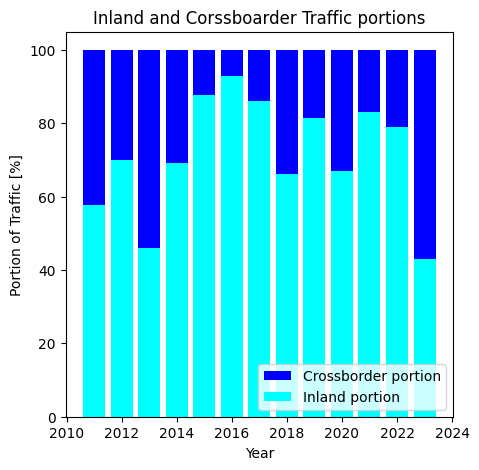

In [363]:
# calc overall traffic per year
yearly = expanded_df_with_inland.groupby(["year"])["value_USD"].sum().reset_index()
yearly.rename(columns={"value_USD":"value_usd_with"},inplace=True)

yearly_without_inland = expanded_df_with_inland[expanded_df_with_inland['dst_jurisdictions'] != expanded_df_with_inland['src_jurisdictions']]
yearly["value_usd_without"] = yearly_without_inland.groupby(["year"])["value_USD"].sum().reset_index()["value_USD"]
yearly["inland portion"] = (1-(yearly["value_usd_without"]/yearly["value_usd_with"]))*100

yearly.set_index('year',inplace=True)

# Create a figure and axes
plt.figure(figsize=(5,5))

# Plot the data
#ax.plot(yearly.index, yearly['inland portion'], color='blue',marker="x",linestyle="dashdot",label="BTC FLOW")
plt.bar(yearly.index,100,color="blue",label="Crossborder portion")
plt.bar(yearly.index,yearly["inland portion"],color="cyan",label="Inland portion")

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Portion of Traffic [%]')
plt.title('Inland and Corssboarder Traffic portions')

plt.legend(loc='lower right',ncol=1)

# Display the plot
plt.show()

## Split into src and dst dfs

In [316]:
# divide by btc value
# Do we really need this? Isn't value_asset already the number of tokens?
expanded_df["value_BTC"] = expanded_df["value_USD"] / expanded_df["high"]

# Group by year and juristicion
# those are the aggregated recievers
dst_amounts = expanded_df.groupby(['year', 'dst_jurisdictions'])[['value_USD', 'value_asset', 'value_BTC',"src_label","dst_label"]].sum().reset_index()
dst_amounts = dst_amounts.rename(columns={"dst_jurisdictions":"jurisdictions"})
dst_amounts["jurisdictions_long"] = dst_amounts["jurisdictions"].apply(lambda x: juri_names_long[x] if x in juri_names_long else "NOT FOUND")

# this are the aggregated "spenders"
src_amounts = expanded_df.groupby(['year', 'src_jurisdictions'])[['value_USD', 'value_asset', 'value_BTC',"src_label","dst_label"]].sum().reset_index()
src_amounts = src_amounts.rename(columns={"src_jurisdictions":"jurisdictions"})
src_amounts["jurisdictions_long"] = src_amounts["jurisdictions"].apply(lambda x: juri_names_long[x] if x in juri_names_long else "NOT FOUND")

print("small sanity check here ")
print("merged sum "+str(merged_df["value_USD"].sum()/MRD))
print("expanded sum "+str(expanded_df["value_USD"].sum()/MRD))
print("dst sum "+str(dst_amounts["value_USD"].sum()/MRD))
print("src sum "+str(src_amounts["value_USD"].sum()/MRD))

display(dst_amounts)
display(src_amounts)

small sanity check here 
merged sum 496.0505513644367
expanded sum 496.0505513644367
dst sum 496.05055136443667
src sum 496.0505513644367


,year,jurisdictions,value_USD,value_asset,value_BTC,src_label,dst_label,jurisdictions_long
0,2011,AT,6.900237e+02,1.706566e+10,152.566942,VirwoxVirwoxVirwoxVirwoxVirwoxBtc-EVirwoxVirwo...,VirwoxVirwoxVirwoxVirwoxVirwoxVirwoxVirwoxVirw...,AUSTRIA
1,2011,AU,7.304667e+03,2.448017e+11,2317.486758,Btc-EBtc-Ebitcoin.deBtc-EBtc-EBtc-EBtc-EVircur...,Btc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EB...,AUSTRALIA
2,2011,BR,2.318428e+01,5.567258e+08,5.182737,Mercado BitcoinMercado BitcoinMercado BitcoinM...,Mercado BitcoinMercado BitcoinMercado BitcoinM...,BRAZIL
3,2011,BZ,1.502127e+01,3.805526e+08,3.283691,Btc-EVircurexVircurexVircurexVircurex,VircurexVircurexVircurexVircurexVircurex,BELIZE
4,2011,CA,6.258083e+02,1.637583e+10,153.054066,CavirtexBtc-ECavirtexBtc-ECavirtexCavirtexCavi...,CavirtexCavirtexCavirtexCavirtexCavirtexCavirt...,CANADA
...,...,...,...,...,...,...,...,...
539,2023,TW,2.940324e+06,1.315775e+10,138.170131,"Binance (US, DEX)Binance (US, DEX)Binance (US,...",Max MaicoinMax MaicoinMax MaicoinMax MaicoinMa...,"TAIWAN, PROVINCE OF CHINA"
540,2023,US,1.009485e+09,4.300168e+12,44719.550145,"Binance (US, DEX)Binance (US, DEX)Binance (US,...","Binance (US, DEX)Binance (US, DEX)Binance (US,...",UNITED STATES
541,2023,VG,8.349690e+08,3.007780e+12,31207.820959,"BitfinexBKEXBinance (US, DEX)Binance (US, DEX)...",BitfinexBKEXLBankLBankLBankLBankLBankLBankLBan...,"VIRGIN ISLANDS, BRITISH"
542,2023,VN,1.785469e+03,7.432757e+06,0.079321,"Binance (US, DEX)Binance (US, DEX)Binance (US,...",VindaxVindaxVindaxVindaxVindaxVindaxVindaxVind...,VIET NAM


,year,jurisdictions,value_USD,value_asset,value_BTC,src_label,dst_label,jurisdictions_long
0,2011,AT,3.138160e+03,7.706882e+10,665.530575,VirwoxVirwoxVirwoxVirwoxVirwoxVirwoxVirwoxVirw...,VirwoxVirwoxVirwoxVirwoxBtccVirwoxTheRockTradi...,AUSTRIA
1,2011,AU,7.136616e+03,2.368486e+11,2209.622132,Btc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EBtc-EB...,Btc-EBtc-ECavirtexBtc-ECavirtexBtc-EBtc-EBtccB...,AUSTRALIA
2,2011,BR,2.318428e+01,5.567258e+08,5.182737,Mercado BitcoinMercado BitcoinMercado BitcoinM...,Mercado BitcoinMercado BitcoinMercado BitcoinM...,BRAZIL
3,2011,BZ,7.382611e+01,1.778907e+09,15.484480,VircurexVircurexVircurexVircurexVircurexVircurex,Btc-EVircurexVircurexBtc-EVircurexVircurex,BELIZE
4,2011,CA,2.603046e+02,7.581569e+09,73.089132,CavirtexCavirtexCavirtexCavirtexCavirtexCavirt...,CavirtexCavirtexCavirtexCavirtexCavirtexBitcoi...,CANADA
...,...,...,...,...,...,...,...,...
527,2023,TR,3.586025e+08,1.542576e+12,16273.558960,BtcTurk PROBtcTurk PROBtcTurk PROBtcTurk PROBt...,"BiboxBinance (US, DEX)Binance (US, DEX)Binance...",TURKEY
528,2023,TW,6.440293e+06,2.779898e+10,285.915718,Max MaicoinMax MaicoinMax MaicoinMax MaicoinMa...,"MEXC GlobalMax MaicoinBinance (US, DEX)Binance...","TAIWAN, PROVINCE OF CHINA"
529,2023,US,7.922750e+08,3.369569e+12,35033.313535,"Binance (US, DEX)CoinbaseBinance (US, DEX)Coin...","CexCexHuobiHuobiHuobiBinance (US, DEX)Binance ...",UNITED STATES
530,2023,VG,8.338058e+08,3.003396e+12,31162.238132,BitfinexBKEXBTSEBKEXBKEXBTSEBKEXBKEXBTSEBKEXBK...,BitfinexBKEXBTSECoinbaseBKEXBTSECoinbaseBKEXBT...,"VIRGIN ISLANDS, BRITISH"


In [317]:
# Number of flows after merging and filtering for different locations
print(f'Number of rows in the flow dataset {merged_df.shape[0]}')

Number of rows in the flow dataset 295758


### Frequency of jurisidictions in the flow data

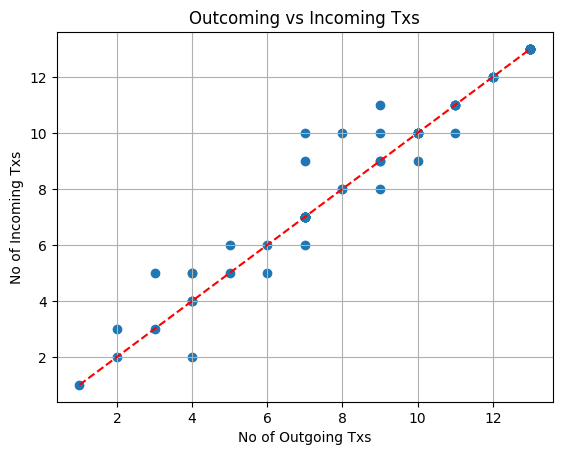

,count_x,count_y
jurisdictions,,
AU,13,13
SK,13,13
BR,13,13
BZ,13,13
CA,13,13
...,...,...
GI,3,5
GE,3,3
VU,2,3


,count_x,count_y
jurisdictions,,
AU,13,13
DE,13,13
US,13,13
IT,13,13
GB,13,13
...,...,...
GI,3,5
GE,3,3
VU,2,3


,count_x,count_y
jurisdictions,,
AU,13,13
BR,13,13
BZ,13,13
CA,13,13
DE,13,13
...,...,...
GE,3,3
VU,2,3
IE,4,2


jurisdictions
AU    13
SK    13
BR    13
BZ    13
CA    13
DE    13
GB    13
IT    13
US    13
VG    12
Name: count, dtype: int64

jurisdictions
US    13
BR    13
BZ    13
CA    13
DE    13
GB    13
IT    13
AU    13
SK    13
AT    12
Name: count, dtype: int64

PearsonRResult(statistic=0.972128499901013, pvalue=3.9109832979056e-40)

In [318]:
src_juri_freq = src_amounts.jurisdictions.value_counts()
dst_juri_freq = dst_amounts.jurisdictions.value_counts()
merged_freq = pd.merge(src_juri_freq, dst_juri_freq, left_index=True, right_index=True, how='inner')


plt.scatter(x=merged_freq.count_x, y=merged_freq.count_y)
plt.xlabel('No of Outgoing Txs')
plt.ylabel('No of Incoming Txs')
plt.title('Outcoming vs Incoming Txs')
plt.grid(True)
line = np.linspace(min(merged_freq.count_x), max(merged_freq.count_y), 100)
plt.plot(line, line, color='r', linestyle='--')
plt.savefig('distribute.png')
plt.show()

display(merged_freq)
display(merged_freq.sort_values(by='count_x', ascending=False))
display(merged_freq.sort_values(by='count_y', ascending=False))
display(src_juri_freq.head(10))
display(dst_juri_freq.head(10))

corr = pearsonr(merged_freq.count_x, merged_freq.count_y)
display(corr)


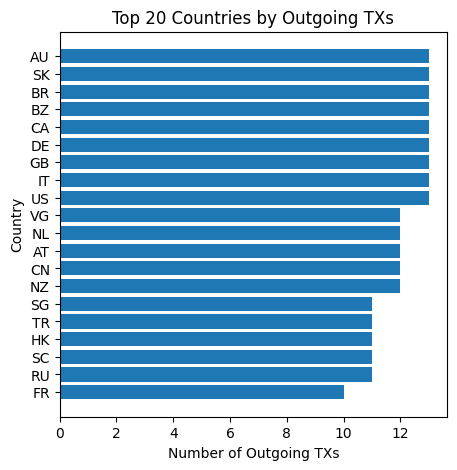

In [319]:
# Plot top 20 in terms of incoming tx
top20_src = src_juri_freq.head(20)
plt.figure(figsize=(5, 5)) 
plt.barh(top20_src.index[::-1], top20_src.values[::-1])
plt.xlabel('Number of Outgoing TXs')
plt.ylabel('Country')
#plt.xticks(range(1, 25), range(1, 25))
plt.title('Top 20 Countries by Outgoing TXs')
plt.savefig('outgoing_top20.png')
plt.show()

In [320]:
# Total value of incoming / outgoing tx
# TODO UNITS ON AXED also maybe scale to BN USD? 
# TODO FIX THIS? (is there even any value in this?)

'''
src_juri_sum = merged_df.groupby('src_jurisdictions')['src_value_USD'].sum()
dst_juri_sum = merged_df.groupby('dst_jurisdictions')['dst_value_USD'].sum()
merged_sum = pd.merge(src_juri_sum, dst_juri_sum, left_index=True, right_index=True, how='inner')
fig, ax = plt.subplots()
scatter = ax.scatter(x=merged_sum.src_value_USD, y=merged_sum.dst_value_USD)
plt.xlabel('USD value of Outgoing Txs')
plt.ylabel('USD value of Incoming Txs')
plt.title('Outcoming vs Incoming Txs USD value')
plt.grid(True)

line = np.linspace(min(merged_sum.src_value_USD), max(merged_sum.dst_value_USD), 100)
plt.plot(line, line, color='r', linestyle='--')
plt.show()

display(merged_sum.sort_values(by='src_value_USD', ascending=False))
display(merged_sum.sort_values(by='dst_value_USD', ascending=False))

corr = pearsonr(merged_sum.src_value_USD, merged_sum.dst_value_USD)
display(corr)
'''

"\nsrc_juri_sum = merged_df.groupby('src_jurisdictions')['src_value_USD'].sum()\ndst_juri_sum = merged_df.groupby('dst_jurisdictions')['dst_value_USD'].sum()\nmerged_sum = pd.merge(src_juri_sum, dst_juri_sum, left_index=True, right_index=True, how='inner')\nfig, ax = plt.subplots()\nscatter = ax.scatter(x=merged_sum.src_value_USD, y=merged_sum.dst_value_USD)\nplt.xlabel('USD value of Outgoing Txs')\nplt.ylabel('USD value of Incoming Txs')\nplt.title('Outcoming vs Incoming Txs USD value')\nplt.grid(True)\n\nline = np.linspace(min(merged_sum.src_value_USD), max(merged_sum.dst_value_USD), 100)\nplt.plot(line, line, color='r', linestyle='--')\nplt.show()\n\ndisplay(merged_sum.sort_values(by='src_value_USD', ascending=False))\ndisplay(merged_sum.sort_values(by='dst_value_USD', ascending=False))\n\ncorr = pearsonr(merged_sum.src_value_USD, merged_sum.dst_value_USD)\ndisplay(corr)\n"

### Trading Pairs frequency

<Axes: ylabel='trading_pairs'>

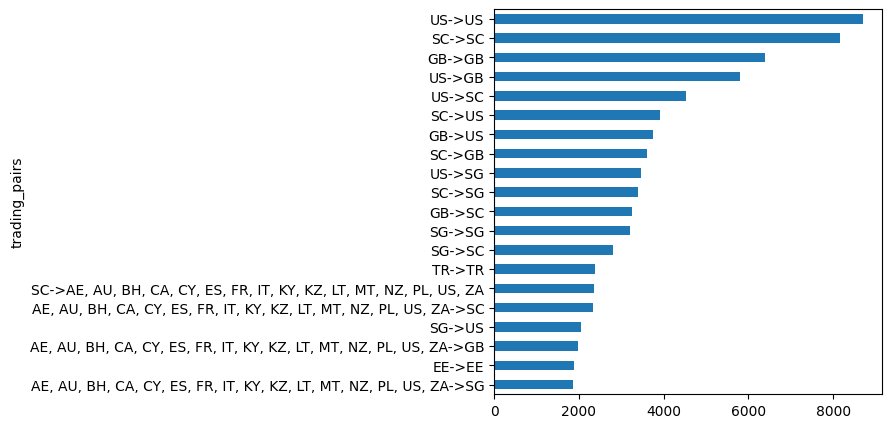

In [321]:
merged_df['trading_pairs'] = merged_df['src_jurisdictions'] + '->' + merged_df['dst_jurisdictions']

merged_df.trading_pairs.value_counts().head(20)[::-1].plot.barh(figsize=(5, 5))

In [322]:
display(merged_df)

,src_id,dst_id,value_asset,value_USD,date,src_uri,src_label,src_jurisdictions,src_categories,dst_uri,dst_label,dst_jurisdictions,dst_categories,high,year,trading_pairs
0,1coin,1coin,333900098,2092.574397,2014-03-14,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange,461.254980,2014,"CA, US->CA, US"
1,bitfinex,bitfinex,3279364990,20552.001559,2014-03-14,bitfinex.com,Bitfinex,VG,exchange,bitfinex.com,Bitfinex,VG,exchange,461.254980,2014,VG->VG
2,bitstamp,bitfinex,2783769806,17446.072812,2014-03-14,bitstamp.net,Bitstamp,GB,exchange,bitfinex.com,Bitfinex,VG,exchange,461.254980,2014,GB->VG
3,cex,bitfinex,1000000,6.267068,2014-03-14,cex.io,Cex,GB,exchange,bitfinex.com,Bitfinex,VG,exchange,461.254980,2014,GB->VG
4,cryptsy,bitfinex,129885463,814.000978,2014-03-14,cryptsy.com,Cryptsy,US,exchange,bitfinex.com,Bitfinex,VG,exchange,461.254980,2014,US->VG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295753,virwox,virwox,412000001,36.012922,2011-05-31,virwox.com,Virwox,AT,exchange,virwox.com,Virwox,AT,exchange,8.758259,2011,AT->AT
295754,virwox,virwox,1000000,0.185499,2011-06-06,virwox.com,Virwox,AT,exchange,virwox.com,Virwox,AT,exchange,17.804963,2011,AT->AT
295755,virwox,virwox,12969814,2.271014,2011-06-25,virwox.com,Virwox,AT,exchange,virwox.com,Virwox,AT,exchange,16.543933,2011,AT->AT
295756,virwox,virwox,67982084,9.388327,2011-07-15,virwox.com,Virwox,AT,exchange,virwox.com,Virwox,AT,exchange,13.829063,2011,AT->AT


In [323]:
country_codes

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
244,Wallis and Futuna,WF,WLF,876,ISO 3166-2:WF,Oceania,Polynesia,NaN,9.0,61.0,NaN
245,Western Sahara,EH,ESH,732,ISO 3166-2:EH,Africa,Northern Africa,NaN,2.0,15.0,NaN
246,Yemen,YE,YEM,887,ISO 3166-2:YE,Asia,Western Asia,NaN,142.0,145.0,NaN
247,Zambia,ZM,ZMB,894,ISO 3166-2:ZM,Africa,Sub-Saharan Africa,Eastern Africa,2.0,202.0,14.0


In [324]:
# TODO: FIX THIS
# WHICH QUESTION DOES THIS AWNSER FOR US?

'''
pairs = merged_df.copy()
grouped_df = pairs.groupby(['src_jurisdictions', 'dst_jurisdictions'])['value_USD'].sum()
src_countries = list(grouped_df.index.get_level_values(0).unique())
dst_countries = list(grouped_df.index.get_level_values(1).unique())
all_countries = list(set(src_countries + dst_countries))

countries_index = {}
for i, country in enumerate(all_countries):
    countries_index[country] = i

sources = []
target = []
values = []
for element in grouped_df.index:
    src = element[0]
    dst = element[1]
    value = grouped_df[element]
    
    #if value > 5000000000:
    if dst == 'AT' and value > 10000000:
        sources.append(countries_index[src])
        target.append(countries_index[dst] + len(countries_index))
        values.append(value)

print(len(values))
# Sankey Diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = all_countries + all_countries,
      color = "gray"
    ),
    link = dict(
      source = sources, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = target,
      value = values
  ))])

fig.update_layout(title_text="Crypto Flow", font_size=10)
fig.show()

'''

'\npairs = merged_df.copy()\ngrouped_df = pairs.groupby([\'src_jurisdictions\', \'dst_jurisdictions\'])[\'value_USD\'].sum()\nsrc_countries = list(grouped_df.index.get_level_values(0).unique())\ndst_countries = list(grouped_df.index.get_level_values(1).unique())\nall_countries = list(set(src_countries + dst_countries))\n\ncountries_index = {}\nfor i, country in enumerate(all_countries):\n    countries_index[country] = i\n\nsources = []\ntarget = []\nvalues = []\nfor element in grouped_df.index:\n    src = element[0]\n    dst = element[1]\n    value = grouped_df[element]\n    \n    #if value > 5000000000:\n    if dst == \'AT\' and value > 10000000:\n        sources.append(countries_index[src])\n        target.append(countries_index[dst] + len(countries_index))\n        values.append(value)\n\nprint(len(values))\n# Sankey Diagram\nfig = go.Figure(data=[go.Sankey(\n    node = dict(\n      pad = 15,\n      thickness = 20,\n      line = dict(color = "black", width = 0.5),\n      label = all

### How does the general trend look like?

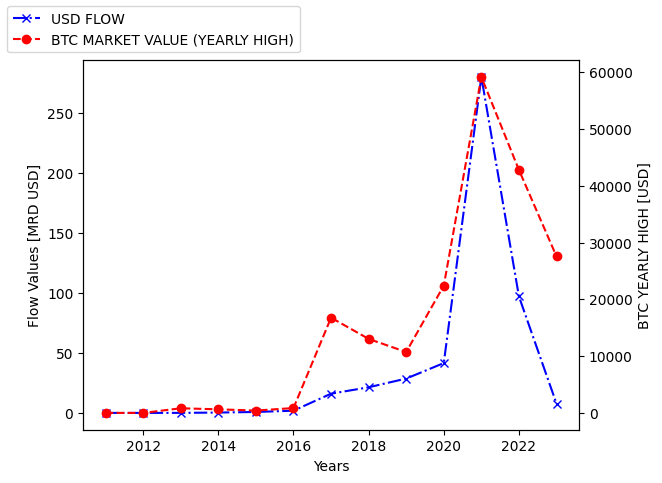

In [325]:
def test_plot(flow_data, btc_data):
    _flow_data = flow_data.groupby('year')["value_USD"].sum()/MRD
    _btc_data = btc_data.groupby('year')["high"].max()

    fig, ax1 = plt.subplots()

    # Plotting the bar plot
    ax1.plot(_flow_data.index, _flow_data.values, color='blue',marker="x",linestyle="dashdot",label="USD FLOW")
    ax1.set_ylabel('Flow Values [MRD USD]')
    ax2 = ax1.twinx()

    # Plotting the line plot
    ax2.plot(_flow_data.index, _btc_data.values, color='red', marker='o', linestyle="dashed",label="BTC MARKET VALUE (YEARLY HIGH)")
    ax2.set_ylabel('BTC YEARLY HIGH [USD]')
    ax1.set_xlabel('Years')
    fig.legend(loc='upper left',ncol=1)

    #plt.tight_layout()

test_plot(src_amounts, btc_price_data)
#test_plot(dst_amounts)

looks like Flow value and the BTC market value correlate - does that mean that the amount of BTC flowing (=flow value/ btc market value) is constant? Lets see

In [326]:
def test_plot2(flow_data,btc_data):
    # TODO: can we use the assets or should we use BTC_value?
    _flow_data = flow_data.groupby('year')["src_value_asset"].sum()/1000000
    _btc_data = btc_data.groupby('year')["high"].max()

    fig, ax1 = plt.subplots()

    # Plotting the bar plot
    ax1.plot(_flow_data.index, _flow_data.values, color='blue',marker="x",linestyle="dashdot",label="BTC FLOW")
    ax1.set_ylabel('Flow Values [MIO BTC]')
    ax2 = ax1.twinx()

    # Plotting the line plot
    ax2.plot(_flow_data.index, _btc_data.values, color='red', marker='o', linestyle="dashed",label="BTC MARKET VALUE (YEARLY HIGH)")
    ax2.set_ylabel('BTC YEARLY HIGH [USD]')
    ax1.set_xlabel('Years')
    fig.legend(loc='upper left',ncol=1)

#test_plot2(src_amounts,btc_price_data)

how are the flows distributed over the jurisdictions?

In [327]:
print(src_amounts["value_USD"].sum()/MRD)
print(dst_amounts["value_USD"].sum()/MRD)
print((src_amounts["value_USD"] - dst_amounts["value_USD"]).sum()/MRD)

496.0505513644367
496.05055136443667
4.116758263151439


In [328]:
def plot_juri_bars(_data1,_data2,l1,l2,year,label):

    #x = dst_amounts["jurisdictions"].unique()
    
    data1 = _data1.copy()
    data1 = data1.sort_values("jurisdictions",ascending=False)
    data1 = data1[data1["year"]==year]
    data1["value_USD"] = (data1["value_USD"]/data1["value_USD"].sum())*100  #convert to % yearly flow
    data1 = data1[data1["value_USD"]>1]
    plotable_data1 = [d for d in zip(data1['year'],data1['jurisdictions'], data1['value_USD']) if d[0] == year]

    

    #data2 = data2[data2["value_USD"]>1]
    data2 = _data2.copy()
    data2 = data2.sort_values("jurisdictions",ascending=False)
    data2 = data2[data2["year"]==year]
    data2["value_USD"] = (data2["value_USD"]/data2["value_USD"].sum())*100    #convert to % yearly flow
    data2 = data2[data2["value_USD"]>1]
    plotable_data2 = [d for d in zip(data2['year'],data2['jurisdictions'], data2['value_USD']) if d[0] == year]

    #display(filtered_data)
    # Separate the x and y values
    x1 = [d[1] for d in plotable_data1]
    y1 = [d[2] for d in plotable_data1]

    x2 = [d[1] for d in plotable_data1]
    y2 = [d[2] for d in plotable_data1]

    fig, (ax1,ax2)= plt.subplots(2,1,figsize=(10,5))

    # Plot the bar chart
    ax1.bar(x1, y1)
    # Set labels and title
    ax1.set_xlabel('Jurisdictions')
    ax1.set_ylabel(f'{l1} % of yearly flow')

    # Plot the bar chart
    ax2.bar(x2, y2)
    # Set labels and title
    ax2.set_xlabel('Jurisdictions')
    ax2.set_ylabel(f'{l2} % of yearly flow')

    # Rotate x-axis labels for better visibility
    ax1.tick_params(axis='x', rotation=90)
    ax2.tick_params(axis='x', rotation=90)

    # Add a label to the plot
    plt.suptitle(label, fontsize=14)

   
    # Display the plot
    plt.show()

interact(plot_juri_bars,_data1=fixed(src_amounts),_data2=fixed(dst_amounts),l1=fixed("Source"),l2=fixed("Destination"),year=(2012,2022,1),label=fixed("Yearly flow values by jursidictions"))

interactive(children=(IntSlider(value=2017, description='year', max=2022, min=2012), Output()), _dom_classes=(…

<function __main__.plot_juri_bars(_data1, _data2, l1, l2, year, label)>

they are all prettymuch "the same" - maybe because binance is in just those juris? lets see

In [329]:
src_filterd = src_amounts[src_amounts["src_label"].str.contains("inance") == False]
src_filterd = src_filterd[src_filterd["dst_label"].str.contains("inance") == False]

dst_filterd = dst_amounts[dst_amounts["src_label"].str.contains("inance") == False]
dst_filterd = dst_filterd[dst_filterd["dst_label"].str.contains("inance") == False]


interact(plot_juri_bars,_data1=fixed(src_filterd),_data2=fixed(dst_filterd),l1=fixed("Source"),l2=fixed("Destination"),year=(2012,2022,1),label=fixed("Yearly flow values by jursidictions without binance"))

interactive(children=(IntSlider(value=2017, description='year', max=2022, min=2012), Output()), _dom_classes=(…

<function __main__.plot_juri_bars(_data1, _data2, l1, l2, year, label)>

In [330]:
result = src_amounts.copy()
result['value_USD'] = src_amounts['value_USD'].sub(dst_amounts['value_USD'], axis=0)
#interact(plot_juri_bars,data1=fixed(result),data2=fixed(result),l1=fixed("Source"),l2=fixed("Destination"),year=(2012,2022,1),label=fixed("Holdings by jurisdictions in"))

Cutoff: 0.6138954343113129


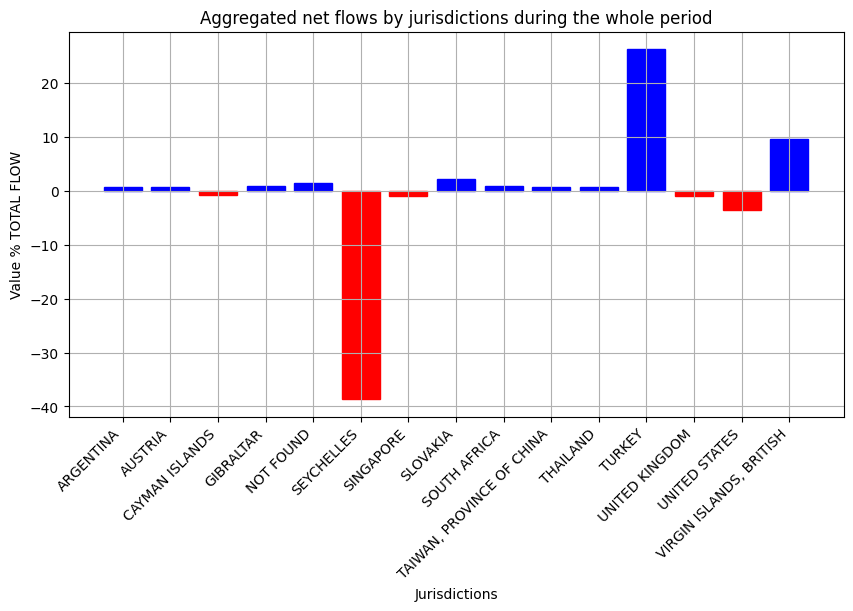

In [340]:
result = src_amounts.copy()
#TODO rethink here why seychells are so negative?? shouldnt they get all the value instead of losing it?
result['value_USD'] = dst_amounts['value_USD'].sub(src_amounts['value_USD'], axis=0)

result = result.groupby(['jurisdictions_long'])['value_USD'].sum().reset_index()
result = result.sort_values("jurisdictions_long",ascending=True)
result["value_USD"] = (result["value_USD"] / result["value_USD"].abs().sum())*100 #convert to %


#filter out the top15
top15_cutoff = float(result["value_USD"].abs().nlargest(15).nsmallest(1).iloc[0])
#print(res["value_USD"].abs().nlargest(15))
print("Cutoff: "+str(top15_cutoff))

result = result[result["value_USD"].abs()>=top15_cutoff]



plt.figure(figsize=(10, 5))

# Plot the bar chart
bars = plt.bar(result['jurisdictions_long'], result['value_USD'])

# Set labels and title
plt.xlabel('Jurisdictions')
plt.ylabel('Value % TOTAL FLOW')
plt.title('Aggregated net flows by jurisdictions during the whole period')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45,ha='right')
plt.grid(True)

# Color the bars based on a condition
for bar, value in zip(bars, result['value_USD']):
    if value < 0:
        bar.set_color('red')
    else:
        bar.set_color('blue')

# Display the plot
plt.show()
#display(result)

interactive(children=(IntSlider(value=2017, description='year', max=2022, min=2012), Output()), _dom_classes=(…

Cutoff: 0.0 % yearly flow
Cutoff: 0.323 % yearly flow
Cutoff: 0.153 % yearly flow
Cutoff: 0.213 % yearly flow
Cutoff: 0.068 % yearly flow
Cutoff: 0.311 % yearly flow
Cutoff: 1.074 % yearly flow
Cutoff: 0.757 % yearly flow
Cutoff: 1.016 % yearly flow
Cutoff: 0.458 % yearly flow
Cutoff: 0.592 % yearly flow


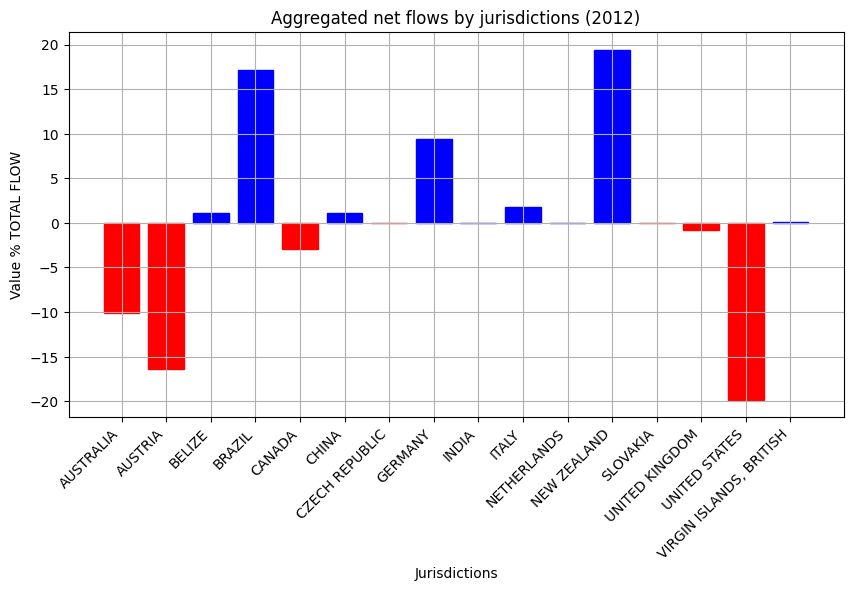

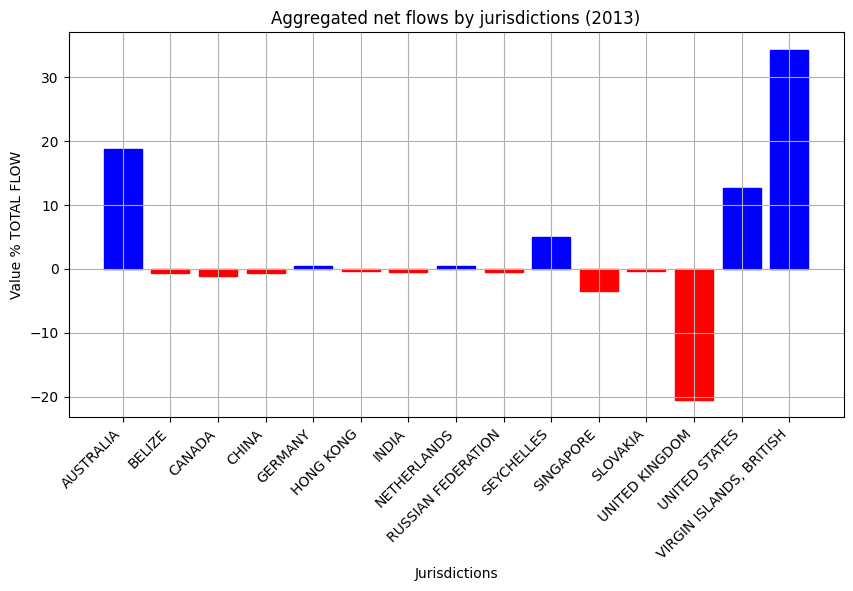

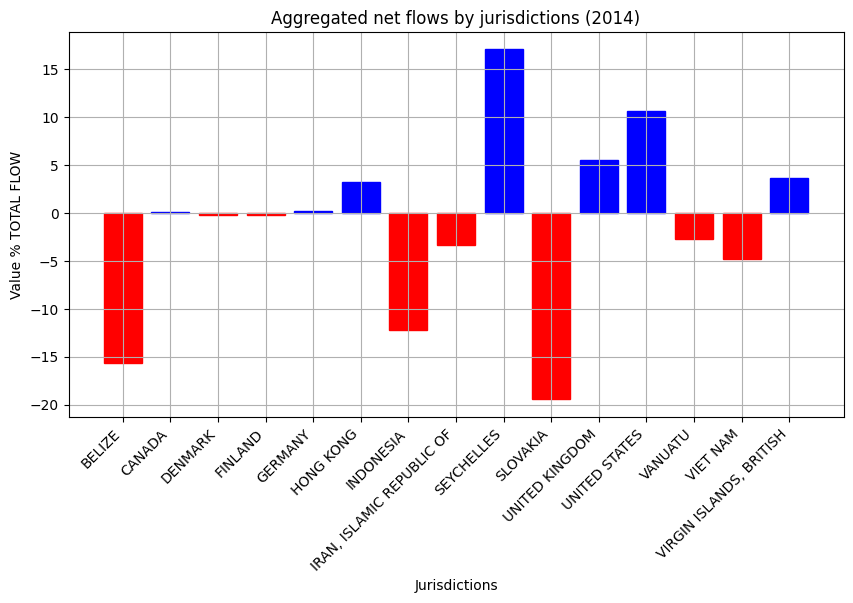

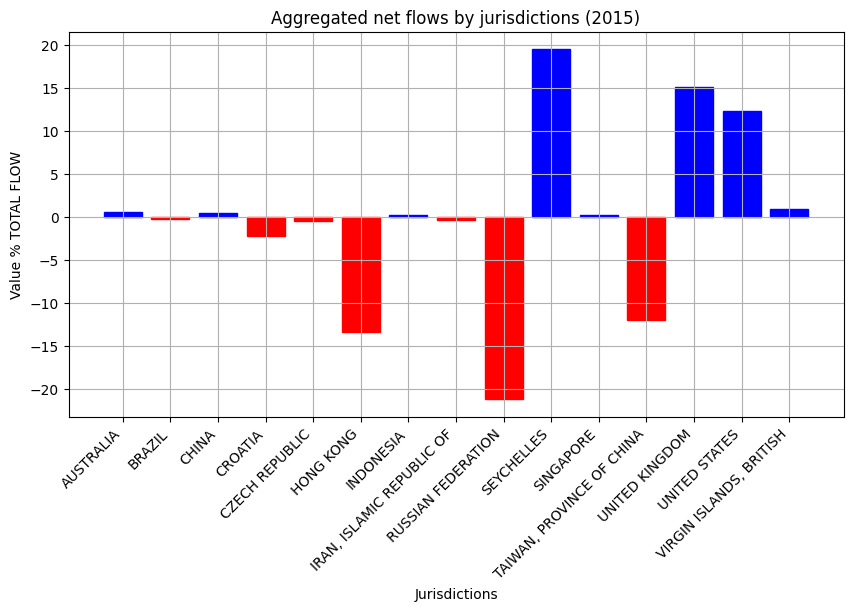

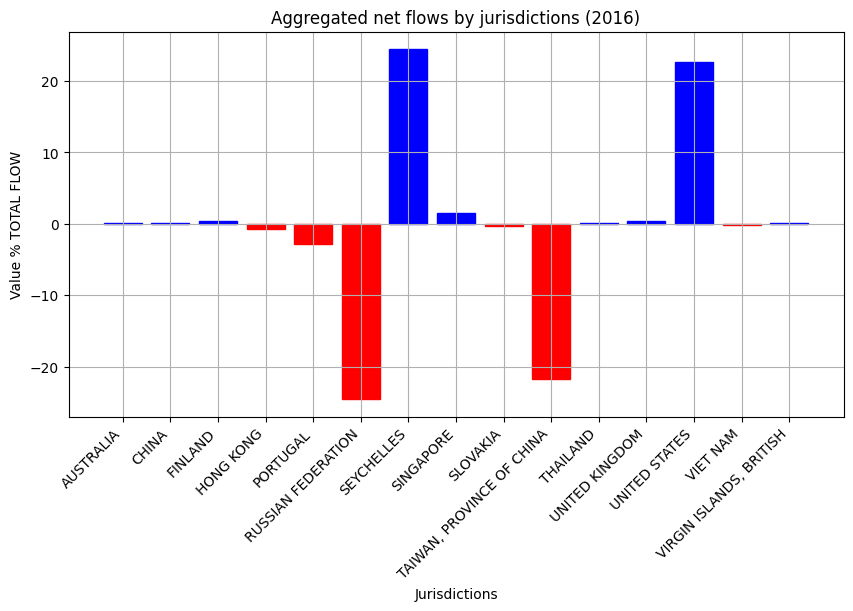

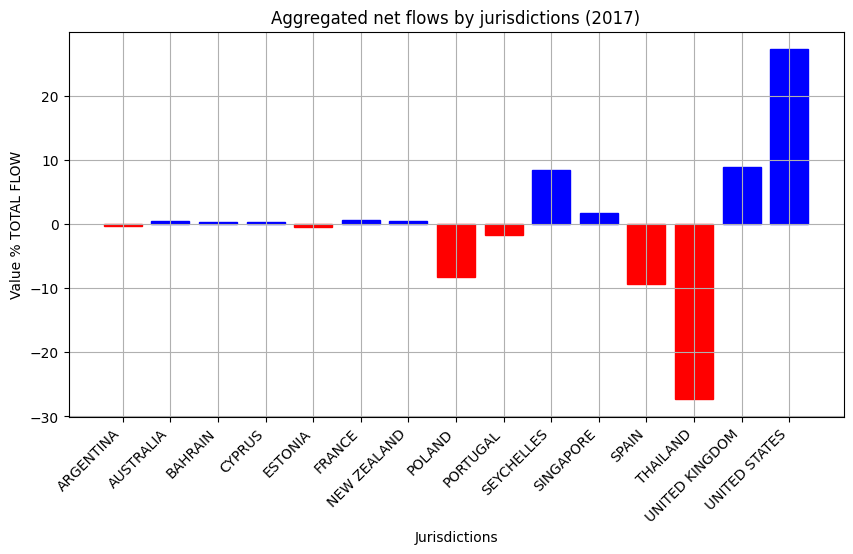

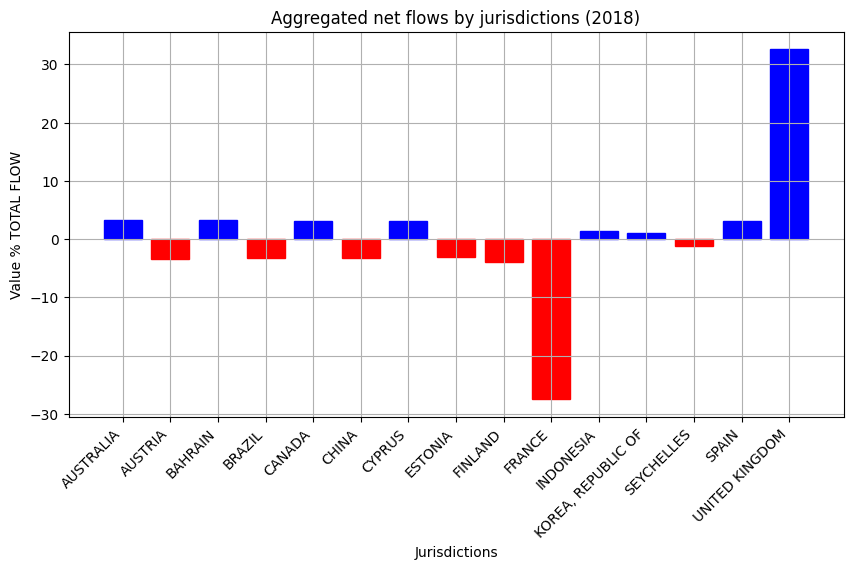

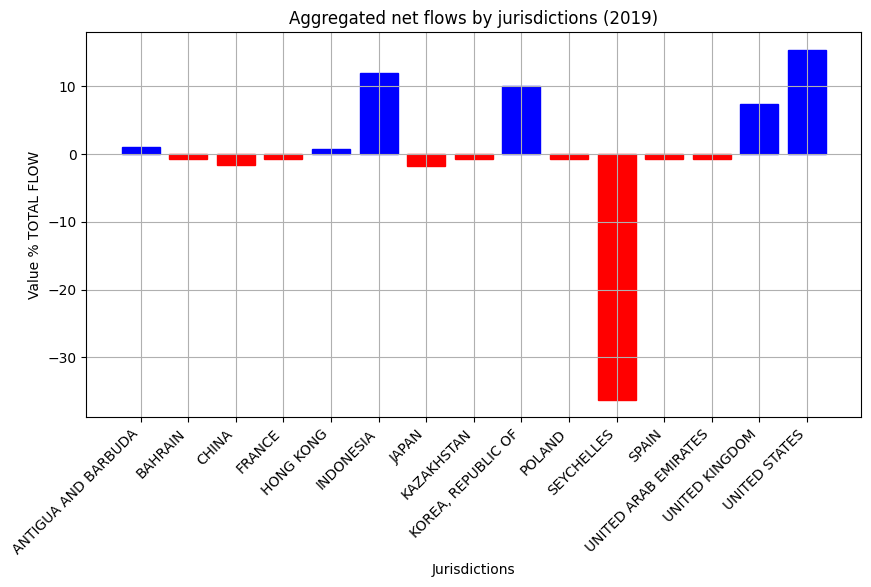

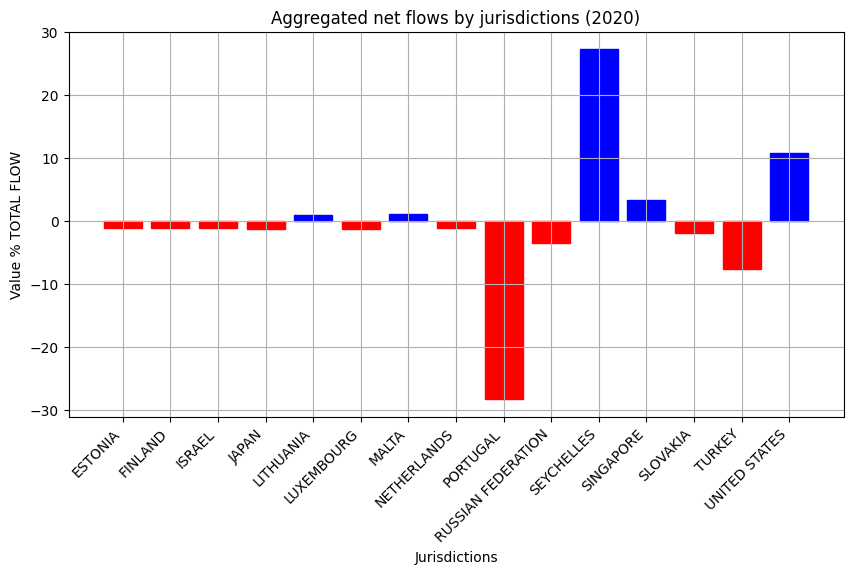

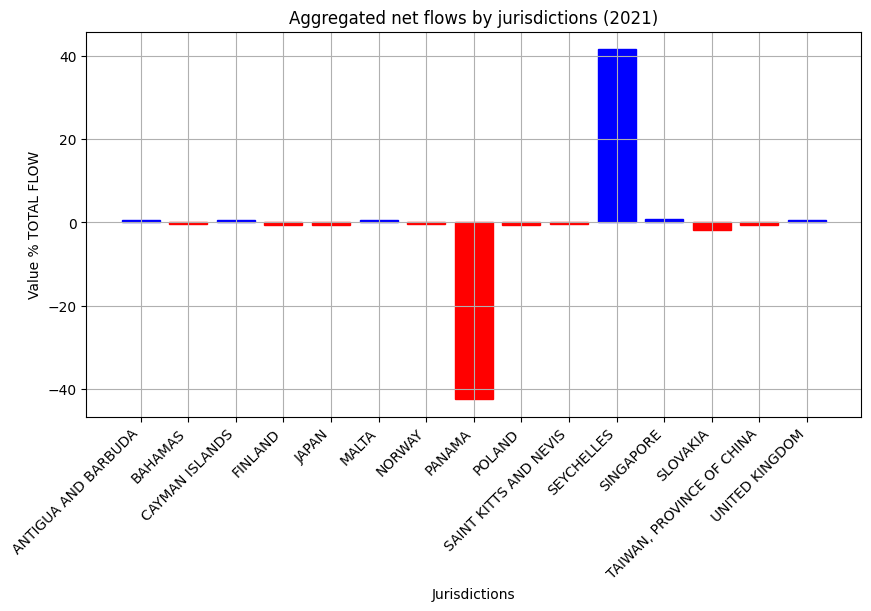

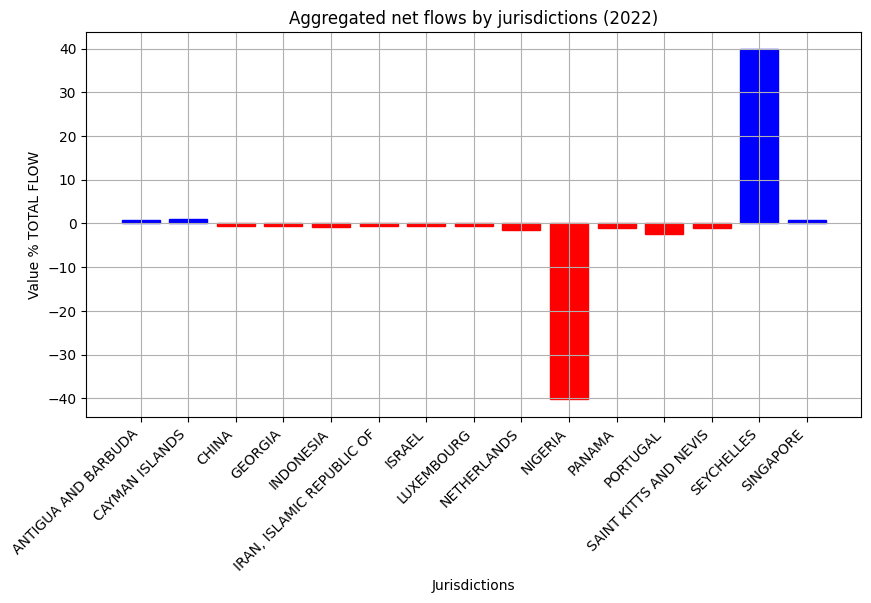

In [355]:
def plot_net_flows_by_year(src_amounts,dst_amounts,year,save):
    _src_amounts = src_amounts.copy()[src_amounts["year"]== year]
    _dst_amounts = dst_amounts.copy()[dst_amounts["year"]== year]

    res = _dst_amounts
    res["value_USD"] = _dst_amounts['value_USD'].sub(_src_amounts['value_USD'], axis=0)
    res = res.groupby(['jurisdictions_long'])['value_USD'].sum().reset_index()

    res = res.sort_values("jurisdictions_long",ascending=True)
    res["value_USD"] =  (res["value_USD"] / res["value_USD"].abs().sum())*100 #convert to %

    #filter out the top15
    top15_cutoff = float(res["value_USD"].abs().nlargest(15).nsmallest(1).iloc[0])#
    #print(res["value_USD"].abs().nlargest(15))
    print("Cutoff: "+str(round(top15_cutoff,3))+" % yearly flow")

    res = res[res["value_USD"].abs()>=top15_cutoff]
    
    plt.figure(figsize=(10, 5))

    # Plot the bar chart
    bars = plt.bar(res['jurisdictions_long'], res['value_USD'])

    # Set labels and title
    plt.xlabel('Jurisdictions')
    plt.ylabel('Value % TOTAL FLOW')
    plt.title('Aggregated net flows by jurisdictions ('+str(year)+')')

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45,ha='right')
    plt.grid(True)

    # Color the bars based on a condition
    for bar, value in zip(bars, res['value_USD']):
        if value < 0:
            bar.set_color('red')
        else:
            bar.set_color('blue')

    # Display the plot
    if(save):
        plt.savefig("figs/aggregated_"+str(year),bbox_inches='tight')
    else:  
        plt.show()

interact(plot_net_flows_by_year,src_amounts=fixed(src_amounts),dst_amounts=fixed(dst_amounts),year=(2012,2022,1),save=fixed(False))

for year in range(2012, 2023):
    plot_net_flows_by_year(src_amounts=src_amounts,dst_amounts=dst_amounts,year=year,save=True)

## What do the flows look like on a map?

interactive(children=(IntSlider(value=2017, description='year', max=2022, min=2012), Output()), _dom_classes=(…

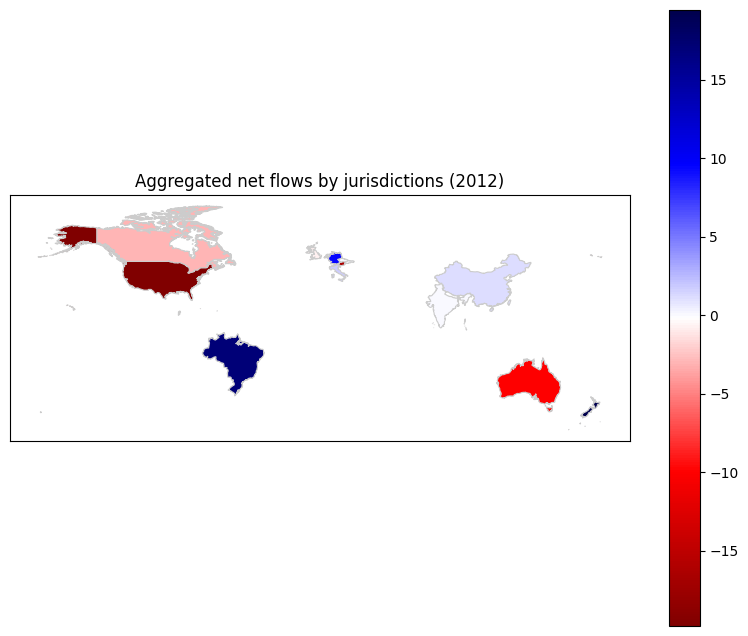

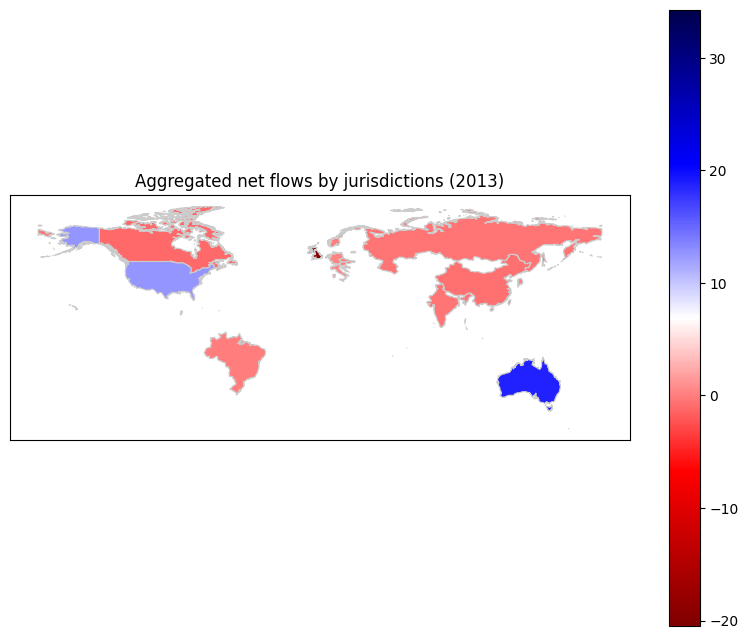

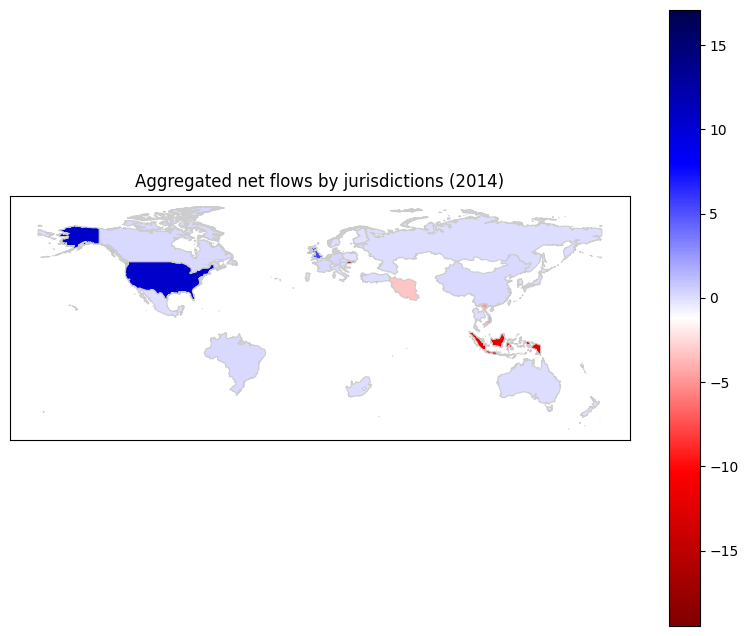

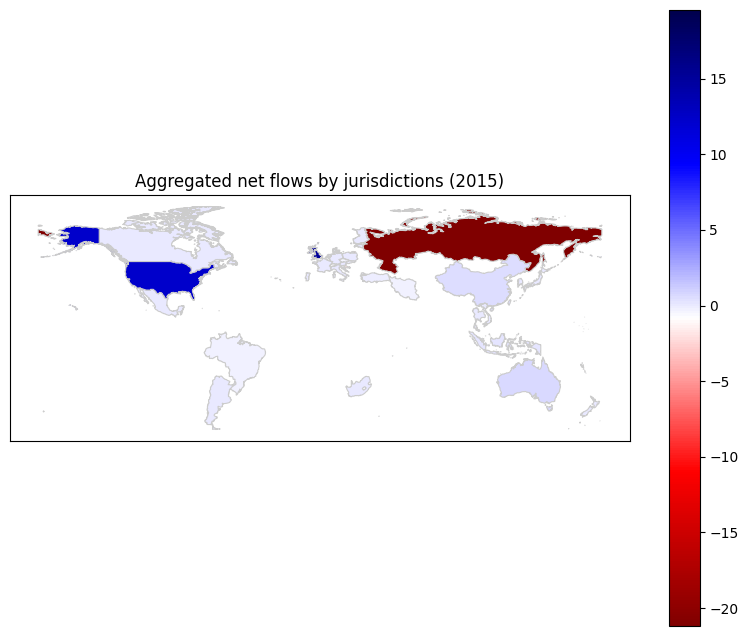

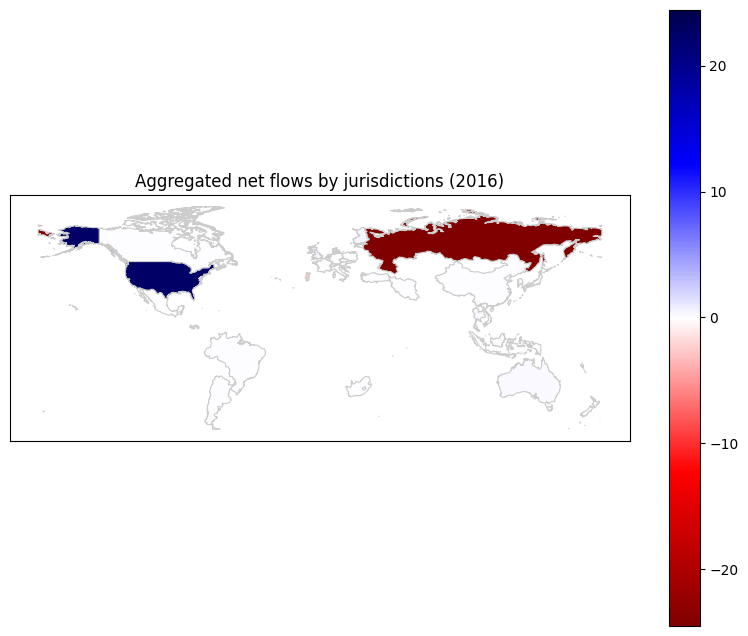

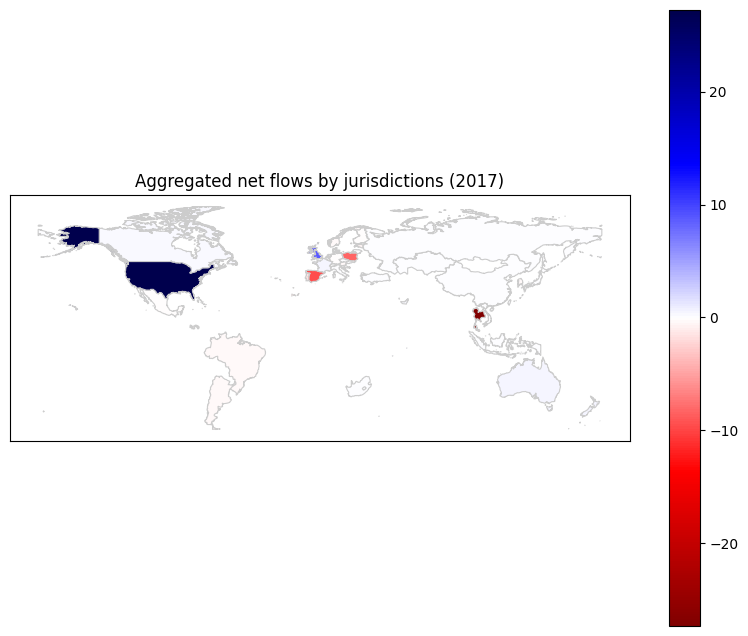

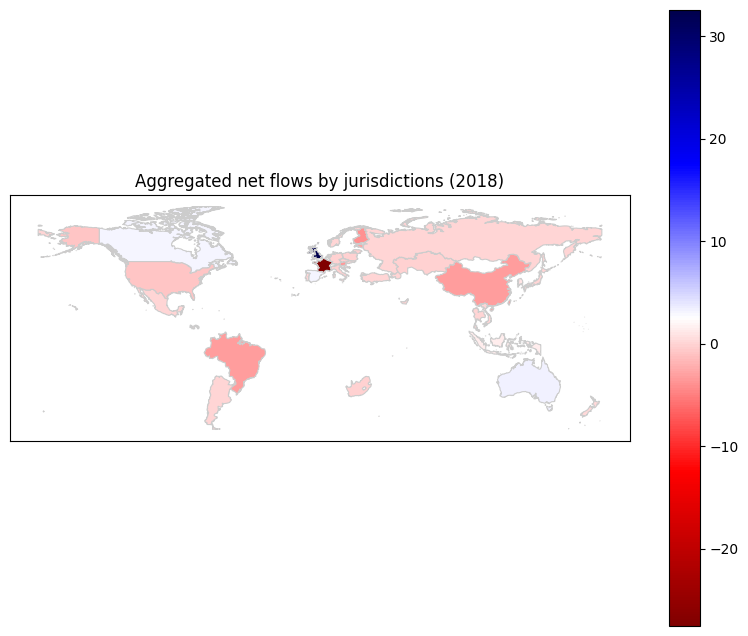

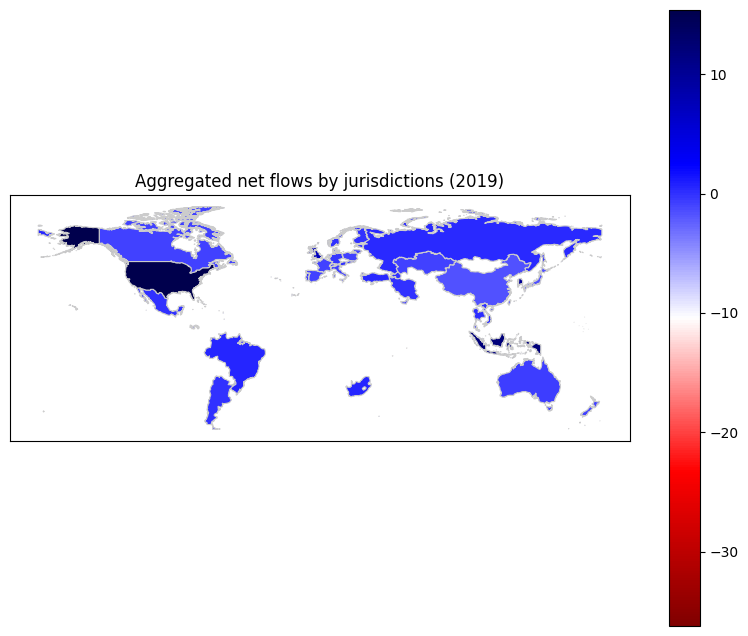

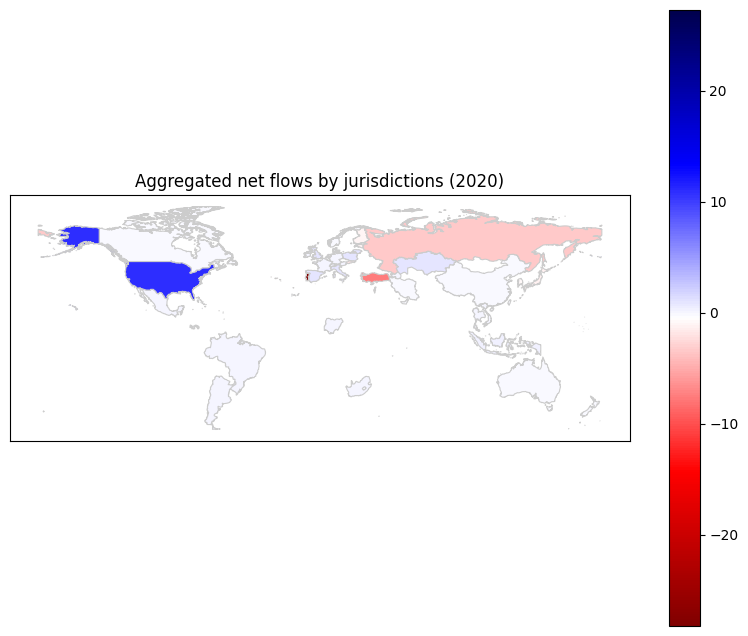

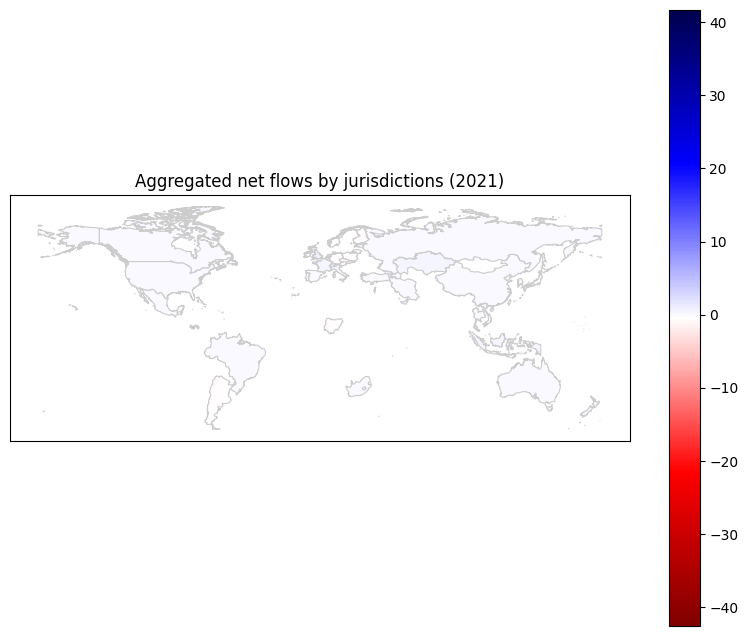

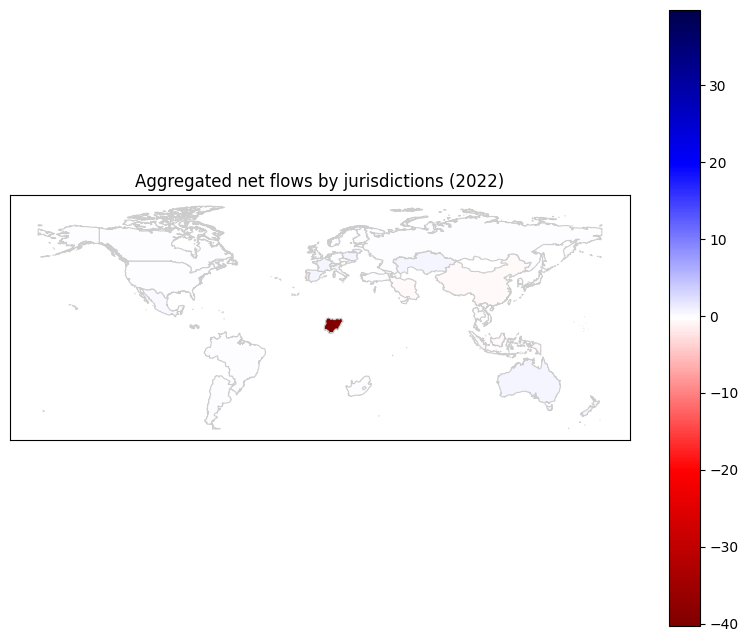

In [354]:
#TODO: fill in "zeros" for all the countries we dont have values so the map isnt so empty
#TODO either make map bigger(prefered) or heatscale smaller
def plot_net_flows_by_year_heatmap(src_amounts,dst_amounts,year,save):
    _src_amounts = src_amounts.copy()[src_amounts["year"]== year]
    _dst_amounts = dst_amounts.copy()[dst_amounts["year"]== year]

    res = _dst_amounts
    res["value_USD"] = _dst_amounts['value_USD'].sub(_src_amounts['value_USD'], axis=0)
    res = res.groupby(['jurisdictions'])['value_USD'].sum().reset_index()

    res = res.sort_values("jurisdictions",ascending=True)
    res["value_USD"] =  (res["value_USD"] / res["value_USD"].abs().sum())*100 #convert to %


    res.rename(columns={'jurisdictions':'alpha-2'},inplace=True)
    country_codes = pd.read_csv('data/country_codes.csv')
    country_codes = country_codes[['alpha-2','alpha-3']]
    c_merged_df= pd.merge(res, country_codes,on='alpha-2',how='inner')
    c_merged_df.rename(columns={'alpha-2':'ISO'},inplace=True)

    map_data = gpd.read_file('shapefile/World_Countries__Generalized_.shp')

    c_merged_data = map_data.merge(c_merged_df, on='ISO')
    fig, ax = plt.subplots(figsize=(10, 8))

    c_merged_data.plot(column='value_USD', cmap='seismic_r', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    ax.set_title('Holdings')
    plt.xticks([])
    plt.yticks([])
    plt.title('Aggregated net flows by jurisdictions ('+str(year)+')')

        # Display the plot
    if(save):
        plt.savefig("figs/heatmap_"+str(year),bbox_inches='tight')
    else:  
        plt.show()
    plt.show()


interact(plot_net_flows_by_year_heatmap,src_amounts=fixed(src_amounts),dst_amounts=fixed(dst_amounts),year=(2012,2022,1),save=fixed(False))

for year in range(2012,2023,1):
    plot_net_flows_by_year_heatmap(src_amounts=src_amounts,dst_amounts=dst_amounts,year=year,save=True)

In [ ]:
# TODO: Merge with GDP Data
# TODO: DELETE THIS????
'''
# Merge country codes first
print(f'Dest Rows before merge: {dst_amounts.shape[0]}')
dst = pd.merge(dst_amounts, country_codes[['alpha-2', 'alpha-3', 'region', 'sub-region']], left_on='dst_jurisdictions', right_on='alpha-2', how='left')

print(f'Src rows before merge: {src_amounts.shape[0]}')
src = pd.merge(src_amounts, country_codes[['alpha-2', 'alpha-3', 'region', 'sub-region']], left_on='src_jurisdictions', right_on='alpha-2', how='inner')
#display(src.head())

# Now merge gdp data
dst = pd.merge(dst, gdp, left_on='alpha-3', right_on='Country Code', how='left')
print(f'Dest rows after merge: {dst.shape[0]}')

src = pd.merge(src, gdp, left_on='alpha-3', right_on='Country Code', how='inner')
print(f'Src rows after merge: {src.shape[0]}')

print(display(dst[dst['alpha-3'].isna()]))
'''

"\n# Merge country codes first\nprint(f'Dest Rows before merge: {dst_amounts.shape[0]}')\ndst = pd.merge(dst_amounts, country_codes[['alpha-2', 'alpha-3', 'region', 'sub-region']], left_on='dst_jurisdictions', right_on='alpha-2', how='left')\n\nprint(f'Src rows before merge: {src_amounts.shape[0]}')\nsrc = pd.merge(src_amounts, country_codes[['alpha-2', 'alpha-3', 'region', 'sub-region']], left_on='src_jurisdictions', right_on='alpha-2', how='inner')\n#display(src.head())\n\n# Now merge gdp data\ndst = pd.merge(dst, gdp, left_on='alpha-3', right_on='Country Code', how='left')\nprint(f'Dest rows after merge: {dst.shape[0]}')\n\nsrc = pd.merge(src, gdp, left_on='alpha-3', right_on='Country Code', how='inner')\nprint(f'Src rows after merge: {src.shape[0]}')\n\nprint(display(dst[dst['alpha-3'].isna()]))\n"

# Correlations

In [ ]:
# Prepare Population
population_country = pd.merge(population, country_codes, left_on='Country Code', right_on='alpha-3', how='inner')

In [ ]:
#TODO FIX THIS
#NameError: name 'population_country' is not defined

flow_data = merged_df.copy()
dst_juri_sum = merged_df.groupby('dst_jurisdictions')['value_USD'].sum()
population_gdp = pd.merge(dst_juri_sum, population_country, left_on='dst_jurisdictions', right_on='alpha-2', how='inner')
'''
fig, ax = plt.subplots()
scatter = ax.scatter(x=np.log10(population_gdp.dst_value_USD), y=population_gdp['2021'])
plt.xlabel('Received USD')
plt.ylabel('Population')
plt.title('Population / Received USD')
plt.grid(True)

corr = pearsonr(population_gdp.dst_value_USD, population_gdp['2021'])
display(corr)
corr = spearmanr(population_gdp.dst_value_USD, population_gdp['2021'])
display(corr)
'''

"\nfig, ax = plt.subplots()\nscatter = ax.scatter(x=np.log10(population_gdp.dst_value_USD), y=population_gdp['2021'])\nplt.xlabel('Received USD')\nplt.ylabel('Population')\nplt.title('Population / Received USD')\nplt.grid(True)\n\ncorr = pearsonr(population_gdp.dst_value_USD, population_gdp['2021'])\ndisplay(corr)\ncorr = spearmanr(population_gdp.dst_value_USD, population_gdp['2021'])\ndisplay(corr)\n"

## TAX HAVEN VS RECIEVED

In [ ]:
# Prepare tax haven data
cthi_country = pd.merge(cthi, country_codes, left_on='Country', right_on='name', how='inner')

PearsonRResult(statistic=0.08017090335718623, pvalue=0.6736568668063169)

SignificanceResult(statistic=0.2503059310182336, pvalue=0.18217786492655752)

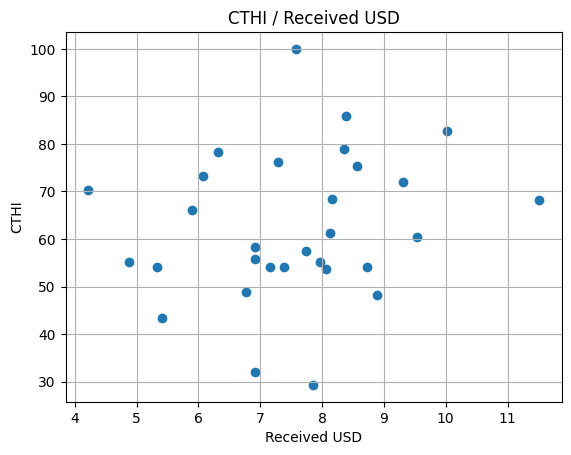

In [ ]:
# CTHI (Tax Haven Score)
# TODO UNITS ON AXED also maybe scale to BN USD? 
flow_data = merged_df.copy()
dst_juri_sum = merged_df.groupby('dst_jurisdictions')['value_USD'].sum()
receivers_cthi = pd.merge(dst_juri_sum, cthi_country, left_on='dst_jurisdictions', right_on='alpha-2', how='inner')

fig, ax = plt.subplots()
scatter = ax.scatter(x=np.log10(receivers_cthi.value_USD), y=receivers_cthi['Haven Score'])
plt.xlabel('Received USD')
plt.ylabel('CTHI')
plt.title('CTHI / Received USD')
plt.grid(True)
corr = pearsonr(receivers_cthi.value_USD, receivers_cthi['Haven Score'])
display(corr)

corr = spearmanr(receivers_cthi.value_USD, receivers_cthi['Haven Score'])
display(corr)


## TAX HAVEN VS SENT
TODO

## CORRUPTION VS RECIEVED

In [ ]:
# Prepare CPI
cpi_country = pd.merge(cpi, country_codes, left_on='Country', right_on='name', how='inner')

PearsonRResult(statistic=-0.01896782756787657, pvalue=0.6976250174329472)

SignificanceResult(statistic=-0.06423808089556211, pvalue=0.1878164516320307)

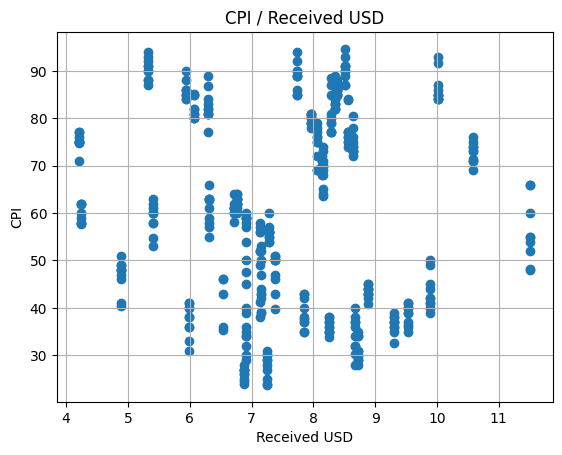

In [ ]:
# TODO UNITS ON AXED also maybe scale to BN USD? 
flow_data = merged_df.copy()
dst_juri_sum = merged_df.groupby('dst_jurisdictions')['value_USD'].sum()
receivers_cpi = pd.merge(dst_juri_sum, cpi_country, left_on='dst_jurisdictions', right_on='alpha-2', how='inner')

fig, ax = plt.subplots()
scatter = ax.scatter(x=np.log10(receivers_cpi.value_USD), y=receivers_cpi['CPI Score'])
plt.xlabel('Received USD')
plt.ylabel('CPI')
plt.title('CPI / Received USD')
plt.grid(True)

corr = pearsonr(receivers_cpi.value_USD, receivers_cpi['CPI Score'])
display(corr)
corr = spearmanr(receivers_cpi.value_USD, receivers_cpi['CPI Score'])
display(corr)

## CORRUPTION VS SENT
TODO

## GDP VS RECIEVED

In [ ]:
# Prepare GDP
gdp_country = pd.merge(gdp, country_codes, left_on='Country Code', right_on='alpha-3', how='inner')

PearsonRResult(statistic=-0.03070485740133081, pvalue=0.8222557516125293)

SignificanceResult(statistic=0.23526999316473002, pvalue=0.0809007778637101)

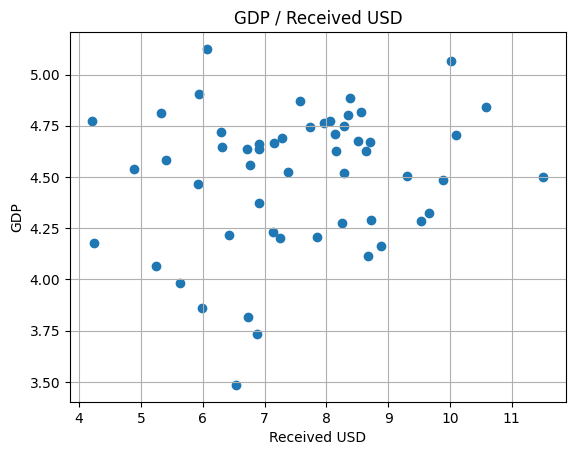

In [ ]:
# TODO UNITS ON AXED also maybe scale to BN USD? 

flow_data = merged_df.copy()
dst_juri_sum = merged_df.groupby('dst_jurisdictions')['value_USD'].sum()
receivers_gdp = pd.merge(dst_juri_sum, gdp_country, left_on='dst_jurisdictions', right_on='alpha-2', how='inner')
receivers_gdp = receivers_gdp.dropna(subset=['2021'])

fig, ax = plt.subplots()
scatter = ax.scatter(x=np.log10(receivers_gdp.value_USD), y=np.log10(receivers_gdp['2021']))
plt.xlabel('Received USD')
plt.ylabel('GDP')
plt.title('GDP / Received USD')
plt.grid(True)

corr = pearsonr(population_gdp.value_USD, population_gdp['2021'])
display(corr)
corr = spearmanr(population_gdp.value_USD, population_gdp['2021'])
display(corr)

## GDP VS RECIEVED
TODO

In [ ]:
gdp_country['2021']

0      42698.359872
1       1665.805842
2       6491.125578
3      15814.411571
4               NaN
           ...     
210     6079.764271
211             NaN
212    14624.415171
213     3555.920229
214     2323.687257
Name: 2021, Length: 215, dtype: float64